In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [1]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost

In [4]:
training_df = pd.read_csv("data/" + "tap_fun_train.csv")

In [49]:
X_havespent = training_df.iloc[:,2:108]
y_havespent = training_df.prediction_pay_price-training_df.pay_price>0

In [53]:
X_havespent_train, X_havespent_test, y_havespent_train, y_havespent_test = train_test_split(X_havespent, y_havespent, test_size=0.3, stratify=y_havespent)

In [58]:
dtrain = xgboost.DMatrix(data=X_havespent_train, label=y_havespent_train)

In [41]:
param = {'max_depth':5, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 100

In [59]:
bst = xgboost.train(param, dtrain, num_round)

In [61]:
dtest = xgboost.DMatrix(data=X_havespent_test)

In [62]:
roc_auc_score(y_havespent_test, bst.predict(dtest))

0.9666185745759999

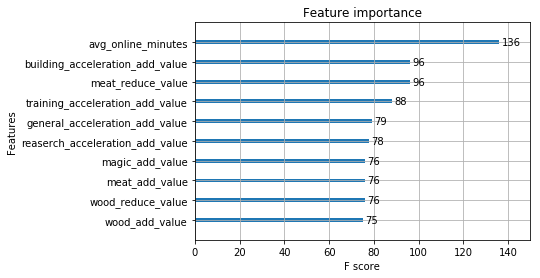

In [70]:
xgboost.plot_importance(bst, max_num_features=10)

In [18]:
training_df[training_df['has_spent']].head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price,has_spent
25,1617,2018-01-26 00:23:42,30000.0,97200.0,20000.0,0.0,0.0,0.0,160500.0,80392.0,...,0,0,0,0,0,44.666667,0.99,1,0.99,True
40,1632,2018-01-26 00:32:43,1111744.0,1137687.0,491331.0,790208.0,77000.0,0.0,1457249.0,708483.0,...,1,1,6,6,6,199.333333,2.97,3,4.96,True
47,1639,2018-01-26 00:40:38,249050.0,173248.0,70841.0,117012.0,55000.0,0.0,206366.0,82205.0,...,0,0,0,0,0,109.333333,12.97,3,12.97,True
86,1678,2018-01-26 01:11:11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,127.833333,0.99,1,0.99,True
119,1711,2018-01-26 01:47:42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,203.166667,0.99,1,0.99,True


In [75]:
training_spender_df = training_df[training_df.prediction_pay_price-training_df.pay_price>0]
X_spender = training_spender_df.iloc[:,2:108]
y_spender = training_spender_df.prediction_pay_price-training_spender_df.pay_price

In [76]:
X_spender_train, X_spender_test, y_spender_train, y_spender_test = train_test_split(X_spender, y_spender, test_size=0.3)

In [77]:
dtrain = xgboost.DMatrix(data=X_spender_train, label=y_spender_train)
dtest = xgboost.DMatrix(data=X_spender_test)

In [79]:
param = {'max_depth':5, 'eta':1, 'silent':1, 'objective':'reg:linear', 'booster':'gbtree'}
num_round = 100

In [80]:
bst_spender_rev = xgboost.train(param, dtrain, num_round)

In [81]:
pred_spender_test = bst_spender_rev.predict(dtest)

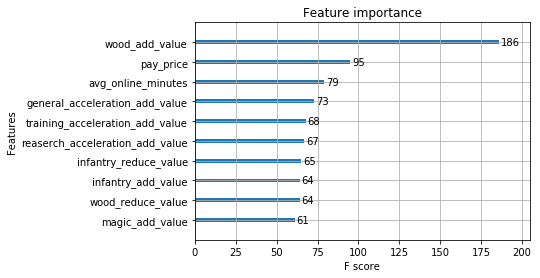

In [83]:
xgboost.plot_importance(bst_spender_rev, max_num_features=10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


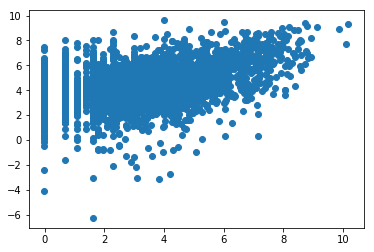

In [89]:
plt.scatter(x=np.log(y_spender_test), y=np.log(pred_spender_test))